In [1]:
#%%
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan

drowning_data = pd.read_fwf('./ex7/drowning.txt').values
years = drowning_data[:, 0]
drowning = drowning_data[:, 1]

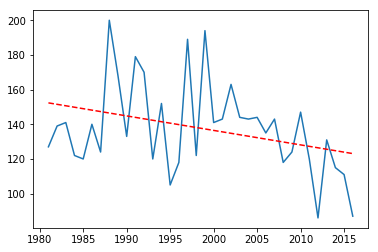

In [2]:
#%%
plt.plot(years, drowning)

z = np.polyfit(years, drowning, 1)
trend = np.poly1d(z)
plt.plot(years, trend(years), 'r--')
plt.show()

In [3]:
#%%
stan_code = '''
data {
  int<lower=0> N; // number of data points
  vector[N] x;    // observation year
  vector[N] y;    // observation number of drowned
  real xpred;     // prediction year
  real tau;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta * x;
}
model {
  beta ~ normal(0, tau);
  y ~ normal(mu, sigma);
}
generated quantities {
  real ypred;
  ypred = normal_rng(alpha + beta * xpred, sigma);
}
'''

In [4]:
#%% guess of tau
dist = norm(loc=0, scale=26.78)
print(dist.cdf(-69))

0.004989593432738089


In [5]:
#%% fitting data to stan model
stan_model = pystan.StanModel(model_code=stan_code)

data = dict(
    N=len(years),
    x=years,
    y=drowning,
    xpred=2019,
    tau=26.78,
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_92320604ec8a3bb0205bb62a379fbdbf NOW.
/Users/maksaddonayorov/.virtualenvs/bda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/qn/_rqylh917b33tgzrfm1wy79h0000gn/T/tmptxdt05kz/stanfit4anon_model_92320604ec8a3bb0205bb62a379fbdbf_3847428440389201310.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [6]:
#%% sampling
fit = stan_model.sampling(data=data)
print(fit)

Inference for Stan model: anon_model_92320604ec8a3bb0205bb62a379fbdbf.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  1791.4   26.83  851.5  133.1 1220.9 1773.5 2331.9 3529.7   1007    1.0
beta    -0.83    0.01   0.43   -1.7   -1.1  -0.82  -0.54 1.4e-3   1007    1.0
sigma   26.53    0.09   3.42  20.88  24.15  26.16  28.61  34.04   1317    1.0
mu[1]  152.17    0.24   8.66 135.68  146.2 152.12  157.8 169.97   1292    1.0
mu[2]  151.35    0.23   8.29 135.63 145.65 151.26  156.8 168.39   1320    1.0
mu[3]  150.52    0.22   7.92 135.48 145.11 150.53 155.73 166.74   1352    1.0
mu[4]  149.69     0.2   7.57 135.27 144.52 149.73 154.68 165.17   1389    1.0
mu[5]  148.86    0.19   7.22 134.97 143.94 148.94 153.57  163.6   1434    1.0
mu[6]  148.04    0.18   6.88 134.71  143.4 148.14  152.5 162.04   1488    1.0
mu[7]  147.21    0.17   6.55 13

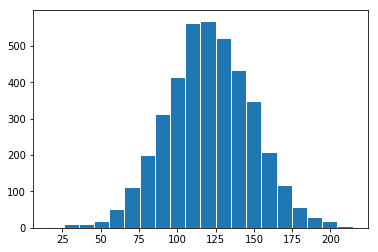

In [7]:
#%% hist
y_pred = fit.extract()['ypred']
plt.hist(y_pred, bins=20, ec='white')
plt.show()